<a href="https://colab.research.google.com/github/codewithAshwani/MNIST-Speech-classification/blob/main/HMM_Speech_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install hmmlearn

In [4]:
import numpy as np
from pickle import dump
from pickle import load
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import StandardScaler
PICKLE_PATH = "feature.pkl"

In [5]:
# Class to handle all HMM related processing
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=6, cov_type='full', n_iter=500):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components, 
                    covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [6]:
def load_data(data_path):
     #Loads training dataset from data file.
     #   :return X (ndarray)
     #   :return y (ndarray)

    data = load(open(data_path, 'rb'))

    # convert lists to numpy arrays
    X = np.array(data["feauture_mfcc"])
    y = np.array(data["labels"])
#    y.astype(int)

    print("Data succesfully loaded!")

    return  X, y

In [7]:
# load data
X, y = load_data(PICKLE_PATH)
num=X.shape[0]
time=X.shape[1]
featu=X.shape[2]
X = X.reshape(num,-1)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling# create train and test split
X=X.reshape(num,time,-1)
#X=X/X.max()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape,y_train.shape)

Data succesfully loaded!
(2700, 55, 13) (2700,)


10

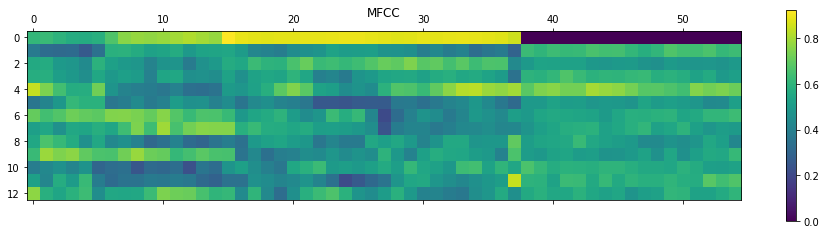

In [8]:
mfcc_features = X_train[2].T
plt.matshow(mfcc_features)
plt.title('MFCC')
plt.colorbar()
len(np.unique(y_train))

In [9]:
hmm_models = []
for i in range(len(np.unique(y_train))):
    X = np.array([])
    y = []
    for X_val, y_val in zip(X_train,y_train):
        if y_val == i:
            if len(X) == 0:
                X = X_val
            else:
                X = np.append(X, X_val, axis=0)
            y.append(y_val)
    print('X.shape =', X.shape,i)
    # Train and save HMM model
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    hmm_models.append((hmm_trainer, i))
    hmm_trainer = None

X.shape = (14850, 13) 0
X.shape = (14905, 13) 1
X.shape = (15345, 13) 2
X.shape = (14960, 13) 3
X.shape = (15125, 13) 4
X.shape = (14190, 13) 5
X.shape = (14795, 13) 6
X.shape = (14960, 13) 7
X.shape = (14630, 13) 8
X.shape = (14740, 13) 9


In [10]:
pred = []
from sklearn.metrics import accuracy_score
for X_val, y_val in zip(X_test,y_test):
    # Define variables
    score = []
    # Iterate through all HMM models 
    for item in hmm_models:
        hmm_model, label = item
        score.append(hmm_model.get_score(X_val))
    pred.append(np.argmax(score))
    y.append(y_val)

In [11]:
pred_result = np.array(pred)
accuracy_score(y_test,pred)

0.9933333333333333

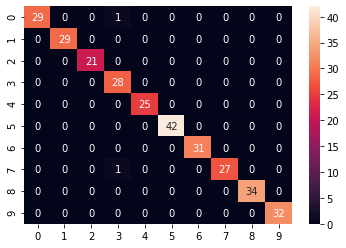

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(cf_matrix, annot=True)